In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import optuna
from optuna.pruners import HyperbandPruner
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = fetch_california_housing(as_frame=True)['frame']

In [3]:
X = fetch_california_housing(as_frame=True)['data']
y = fetch_california_housing(as_frame=True)['target']

In [4]:
fetch_california_housing(as_frame=True)['frame'].head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


Строка датасета - городская группа (наименьшая географическая единица)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


# 1. Разделение данных на обучающую и тестовую выборки

В нашем датасете много данных (20640 записей), поэтому обойдёмся без кросс-валидации. Возьмём стандартное соотношение 80/20, так как данных много. При таком разбиении у нас и будет хватать данных для обучения модели, и будет достаточно много данных для тестирования модели

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Выбираем модель, определяем набор метрик

Выберем следующие метрики:
- MAE (хорошо интерпретируема в данной задаче)
- RMSE (чтобы сильнее штрафовать большие отклонения)
- R2 (чтобы понять, насколько наша модель соответствует данным)
- MAPE (чтобы оценить в процентах ошибку цены дома)

Будем использовать случайный лес, так как деревья помогут нам выделить главные признаки, влияющие на цену дома, а также нелинейные зависимости.

<Axes: >

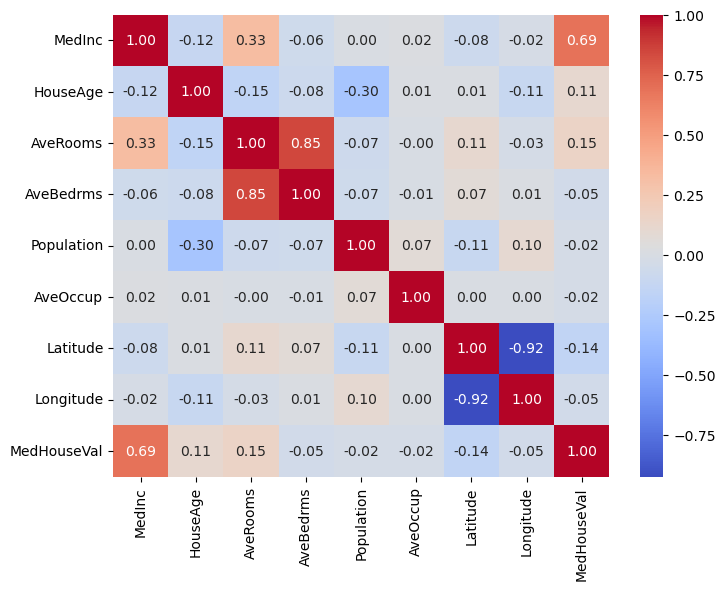

In [7]:
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

In [8]:
def print_metrics(y_true, y_pred):
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.2f}")
    print(f"R2: {r2_score(y_true, y_pred):.2f}")

# 3. Подбираем гиперпараметры

In [9]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    ).fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)
    return score

In [12]:
study = optuna.create_study(direction='minimize', pruner=HyperbandPruner())
study.optimize(objective, n_trials=50)

[I 2025-09-19 18:56:59,872] A new study created in memory with name: no-name-448ab962-95c0-4ab2-b852-c93c50282056
[I 2025-09-19 18:57:03,343] Trial 0 finished with value: 0.36705570986986247 and parameters: {'n_estimators': 24, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.36705570986986247.
[I 2025-09-19 18:57:11,107] Trial 1 finished with value: 0.3345752793731961 and parameters: {'n_estimators': 34, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.3345752793731961.
[I 2025-09-19 18:57:13,530] Trial 2 finished with value: 0.35501902301175686 and parameters: {'n_estimators': 13, 'max_depth': 45, 'min_samples_split': 11, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.3345752793731961.
[I 2025-09-19 18:57:19,772] Trial 3 finished with value: 0.34633955052736637 and parameters: {'n_estimators': 33, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 1 with v

In [13]:
print(f"Лучшие параметры: {study.best_params}")
print(f"Лучший результат: {study.best_value}")

Лучшие параметры: {'n_estimators': 96, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2}
Лучший результат: 0.3267151757949071


In [15]:
best_rf = RandomForestRegressor(**study.best_params).fit(X_train, y_train)

# 4. Получаем предсказание

In [16]:
y_pred = best_rf.predict(X_test)
print("Метрики на тестовых данных")
print_metrics(y_test, y_pred)

Метрики на тестовых данных
MAE: 0.32
RMSE: 0.50
MAPE: 0.19
R2: 0.81


In [17]:
y_pred_train = best_rf.predict(X_train)
print("Метрики на тренировочных данных")
print_metrics(y_train, y_pred_train)

Метрики на тренировочных данных
MAE: 0.14
RMSE: 0.24
MAPE: 0.08
R2: 0.96


# 5. Графики остатков

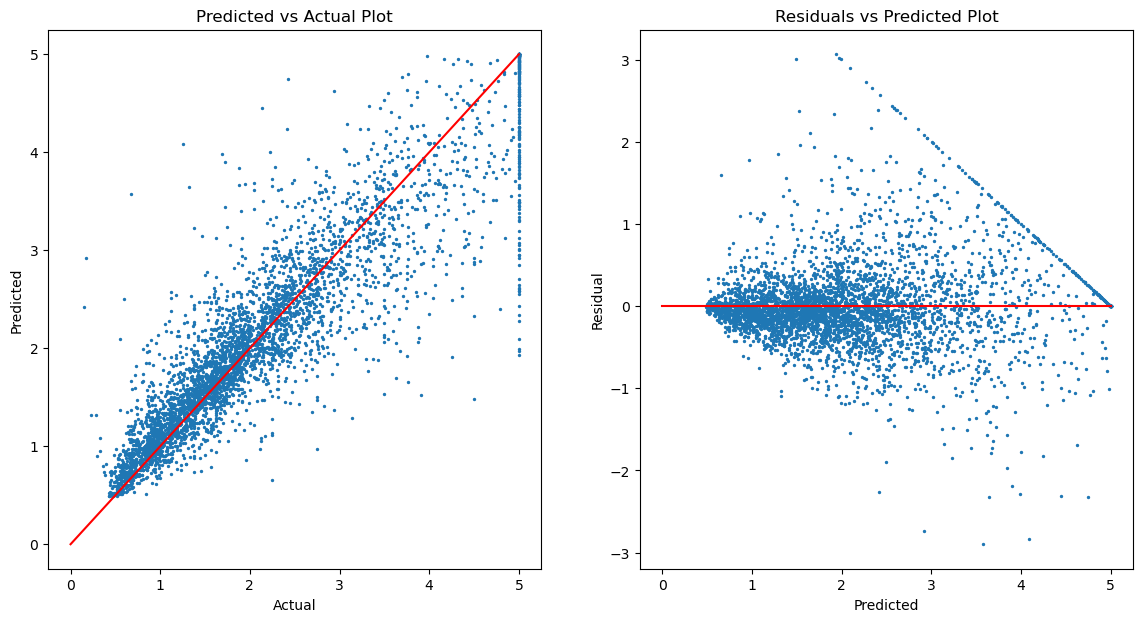

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].plot([0, 5], [0, 5], c='red')
axs[0].scatter(y_test, y_pred, s=2)
axs[0].set_title('Predicted vs Actual Plot')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')

axs[1].plot([0, 5], [0, 0], c='red')
axs[1].scatter(y_pred, y_test - y_pred, s=2)
axs[1].set_title('Residuals vs Predicted Plot')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residual')

plt.show()